# Coding Exercise 3

## Question 1: Optimal Consumption with Income Fluctuations

### The model

Consider a household that maximize

$$
\max_{\{c_t\}_{t = 0}^\infty } \mathbb{E} \sum_{t=0}^{\infty} \beta^t u(c_t),
$$
where $ \beta \in (0,1) $ is the discount factor and $ c_t $ is consumption at time $t$  

subject to

<a id='resource_constraint'></a>
$$
a_{t+1} \leq  (1+r_t) a_t  + w_t h_t - c_t,
\quad c_t \geq 0,
\quad a_t \geq 0
\quad t = 0, 1, \ldots \tag{1}
$$

where

- $ \beta \in (0,1) $ is the discount factor.
- $ a_t $ is asset holdings at the beginning of time $ t $ with a borrowing constraint: $ a_t \geq 0 $ $\forall t$. 
- $ c_t $ is consumption, and $h_t$ is hours worked.
- $ w_t $ is wages and $ r_t $ is the interest rate.

Each period, the household is endowed with one unit of time. Due to the specification of utility function the household inelastically supply the whole hour as labor, i.e., $h_t=1$ for all $t$.

The interest rate ($r_t$) and wages ($w_t$) are given, respectively, $r_t = r(Z_t)$ and $w_t = w(Z_t)$, where $Z_t$ follows a finite state Markov process with a state space $\mathcal{Z}=\{0,1\}$ and a Markov matrix as below:

$$
P = \left[\begin{matrix}
    0.9 & 0.1 \\
    0.1 & 0.9
    \end{matrix}\right]
$$

For simplicity of computation, We assume that $r(0)=0.025$, $r(1)=0.035$, $w(0)=0.8$ and $w(1)=1.2$.

Notice that the resource constraint for the household in [(1)](#resource_constraint) is different from the one that we considered in the lecture. This represents the timing of events within a period as follows:

1. In period $ t $, the household starts the period with asset holds $a_t$ which transmitted from the previous period.
1. At the beginning of period $ t $, the household observes the realizations of the interest rate and wages, $r_t$ and $w_t$ which are determined accoding to the Markov processes.
1. The household receives the gross capital income $(1+r_t) a_t$ and labor income $w_t h_t$. 
1. The household chooses her consumption $c_t$.
1. Time shifts to $ t+1 $ and the process repeats.

It is clear that the state for the household is a pair of $ (a,z) \in \mathsf S := \mathbb R_+ \times \mathcal{Z} $. 

### The Euler Equation

In period $t$, the total resources for the houshold is $(1+r_{t})a_t + w_t$ is disposed of into consumption $c_t$ and the next period asset $a_{t+1}$. Due to the borrowing constraint, $a_{t+1} \ge 0$. Taking this into consideration, the optimal condition for the consumption choices can be summarized by the following Euler equation:

<a id='euler_equation'></a>
$$
u'(c_t) = \max \left\{\beta\, \mathbb{E}_t \left[ (1+r_{t+1}) u'(c_{t+1}) \right], \;  u'\left((1+r_{t})a_t+w_t\right)
\right\} \tag{2}
$$

There exists an *optimal consumption function* $ \sigma^* \colon \mathsf S \to \mathbb R_+ $ that solves [(2)](#euler_equation) for all $ (a,z) \in \mathsf{S} $, i.e., 

<a id='EE'></a>
$$
\begin{aligned}
(u' \circ \sigma) (a, z) &= \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) (\hat{a},\hat{z}) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\\
&= \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) \left((1+r(z))a+w[z]-\sigma(a,z),\hat{z} \right) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\end{aligned}
\tag{3}
$$


Let's solve for the optimal policy for consumption through the **time iteration** method.

### Q.1-0: Import necessary packages.

First, import the following external libraries:

1. `MarkoovChain` from `quantecon` to handle finite state Markov process
1. `brentq` from `quantecon` to solve for the optimal policy at each state. 
1. `interp` from `interpolation` to evaluate the optimal policy an off-grid point.
1. `numba` package to jit-compile class and functions.
1. `pyplot` from `matplotlib` to present results graphically.

In [ ]:
pip install quantecon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install interpolation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# your code here

from quantecon import MarkovChain
from quantecon.optimize import brentq
from quantecon import lorenz_curve, gini_coefficient
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
import matplotlib.pyplot as plt

import numpy as np

### Q.1-1: Define the class for the model economy

Write a class **IFP** that specifies the following.

- discount factor: $\beta = 0.965$
- CRRA parameter: $\gamma=2$
- interest rate values: as specified above
- wage values: as specified above
- Markov matrix: P as specified above
- marginal uility function: $c^{-\gamma}$
- asset grid vector: $a \in [0, 20]$ with grid_size = 200
- collect the model parameters and declare their types in **ifp_data**
- jit-compile the class with `@jitclass`

Assume that the condition for convergence, $\beta E[1+r(\hat{z})] < 1$ is satisfied with the above values for `r` and `beta`.

In [ ]:
# your code here

ifp_data = [('beta', float64),
            ('gamma', float64),
            ('r', float64[:]),
            ('w', float64[:]),
            ('P', float64[:, :]),
            ('asset_grid', float64[:]),
            ('sd', float64[:])
]

@jitclass(ifp_data)
class IFP:

    def __init__(self,
                 beta=0.965,
                 gamma=2,
                 r=np.array([0.025, 0.035]),
                 w=np.array([0.8, 1.2]),
                 P=np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 grid_max=20,
                 grid_size=200):

        self.beta, self.gamma = beta, gamma
        self.r, self.w, self.P = r, w, P
        self.asset_grid = np.linspace(0, grid_max, grid_size)
        
        # 매기 진행됨에 따라 (1 + r(z_hat))의 분포가 바뀔 수 있으므로, 가장 극단적인 분포 (1, 0), (0, 1)에서 만족하는지 확인(다른 분포는 이 두 경우의 linear combination이므로 성립하게 됨)

        assert max(self.beta * (1 + self.r)) < 1, "Stability condition violated."

    def u_prime(self, c):
        return c ** (-self.gamma)

    def euler_diff(self, c, a, z, σ_vals):
        beta, gamma, r, w, P = self.beta, self.gamma, self.r, self.w, self.P
        asset_grid, u_prime = self.asset_grid, self.u_prime
        n = len(P)

        σ = lambda a, z: interp(asset_grid, σ_vals[:, z], a)

        Ez = 0.0
        for z_hat in range(n):
            Ez += (1 + r[z_hat]) * u_prime(σ((1 + r[z]) * a + w[z] - c, z_hat)) * P[z, z_hat]

        return u_prime(c) - max(beta * Ez, u_prime((1 + r[z]) * a + w[z]))

### Q.1-2: Define the Coleman Operator

Write a function that defines the Coleman operator $K$ that updates the optimal policy function $\sigma$ by solving the (nonlinear) Equler equation for $c$ for all $(a,z) \in \mathsf{S}$. 

<a id='EE_sigma'></a>
$$
u'(c) = \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) \left((1+r(z))a+w[z]-c,\hat{z} \right) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\tag{4}
$$

- function head: **K($\sigma$, ifp)**
- $\sigma$ is a matrix of which elements are the optimal consumption $c^*$ for state $(a,z) \in \mathsf S$ in the current iteration.
- `ifp` is the instance of the class IFP to be initiated later.
- solve the nonlinear euqation for $c^*$ for each pair of $(a,z)$ using `brentq` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/root_finding.html) to find the usage of `brentq`.
- update the policy value function $\sigma_{new}$.
- jit-compile the function with @njit

In [ ]:
# your code here

@njit
def K(σ, ifp):

    σ_new = np.empty_like(σ)
    for i, a in enumerate(ifp.asset_grid):
        for z in (0, 1):
            result = brentq(ifp.euler_diff, 1e-8, (1 + ifp.r[z]) * a + ifp.w[z], args=(a, z, σ))
            σ_new[i, z] = result.root

    return σ_new

### Q.1-3: Implement the Time Iteration


Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_(ifp_in, $\sigma$, tol=1e-4, max_iter=1000, print_skip=10)`
- the arguements are analogous to those in the lecture.
- while iterating, the function should show the progress every 10 iteration.
- the function returns the converged policy function.

In [ ]:
# your code here

def solve_model_(ifp_in,
                 σ,
                 tol=1e-4,
                 max_iter=1000,
                 print_skip=10,
                 verbose=True):

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, ifp_in)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

### Q.1-4: Run the Time Iteration

- create an instance of the class IFP `ifp` with the default parameter values defined in the class.
- initialize the optimal consumption matrix $\sigma$ with the asset grid vector for all $z$.
- run `solve_model` and save the converged comsumption policy in a matrix *c_opt*.
- compute the optimal asset holdings in the next period, $\hat{a}$, using *c_opt* and the resource constraint and save them in a matrix *ap_opt*.
- plot *c_opt* for each $z$ against assets ($a$).
- plot *ap_opt* for each $z$ against assets ($a$).


Error at iteration 10 is 0.17802594443483244.
Error at iteration 20 is 0.04524579050420208.
Error at iteration 30 is 0.018916784137316345.
Error at iteration 40 is 0.00963386040760228.
Error at iteration 50 is 0.005864859557748625.
Error at iteration 60 is 0.004291893005179848.
Error at iteration 70 is 0.002860480581169389.
Error at iteration 80 is 0.0018771416384748552.
Error at iteration 90 is 0.001233265422468266.
Error at iteration 100 is 0.0008121057966652412.
Error at iteration 110 is 0.0005346877295344665.
Error at iteration 120 is 0.00035126261957407756.
Error at iteration 130 is 0.0002299410462633933.
Error at iteration 140 is 0.0001498635304009177.
Error at iteration 150 is 9.72055017245399e-05.

Converged in 150 iterations.


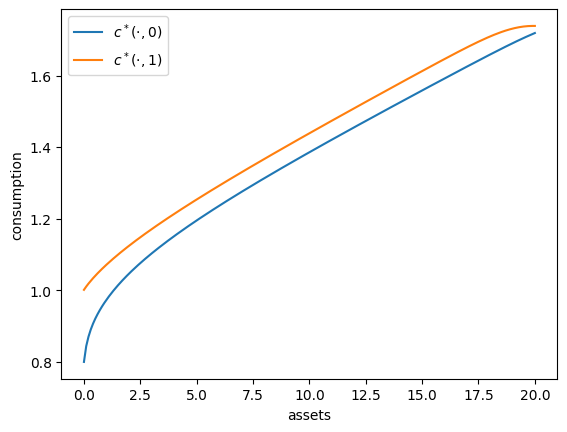

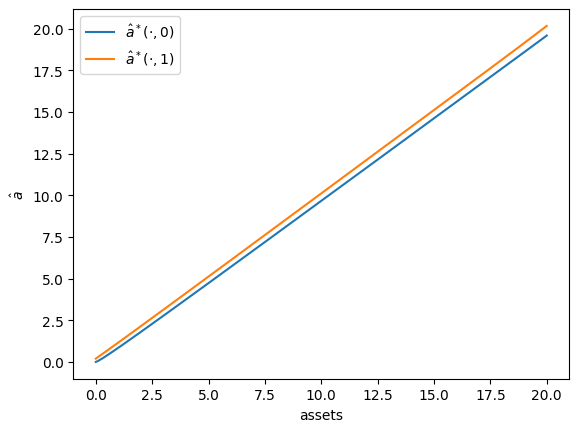

In [ ]:
# your code here

ifp = IFP()

z_size = len(ifp.P)
a_grid = ifp.asset_grid
a_size = len(a_grid)
σ_init = np.repeat(a_grid.reshape(a_size, 1), z_size, axis=1)

c_opt = solve_model_(ifp, σ_init)
ap_opt = np.empty_like(c_opt)
for z in (0, 1):
    for i in range(a_size):
        ap_opt[i, z] = max((1 + ifp.r[z]) * a_grid[i] + ifp.w[z] - c_opt[i, z], 0)

fig, ax = plt.subplots()
for z in range(z_size):
    label = rf'$c^*(\cdot, {z})$'
    ax.plot(a_grid, c_opt[:, z], label=label)
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()

fig, ax = plt.subplots()
for z in range(z_size):
    label = rf'$\hat a^*(\cdot, {z})$'
    ax.plot(a_grid, ap_opt[:, z], label=label)
ax.set(xlabel='assets', ylabel='$\hat{a}$')
ax.legend()
plt.show()

### Q.1-5: Simulate the time-series of asset holdings

Suppose that the household is endowed with $a_0$ at the very first period of her life. Each period, she chooses consumption and the next period assets according to the optimal policy function computed above. Write a function that simulates the asset holdings and consumption of the household over 500,000 periods.

- function head: Simulate_Time_Series(ifp, T, seed=1234)
    - `ifp`: instance of the class IFP
    - `c_opt`: optimal consumption function computed above
    - `T`: length of time-series, set to 500,000
    - `seed`: seed for random number generator, set to 1234
- need to interpolate policy functions
- use `MarkovChain` to generate a series of random numbers from a Markov process with Markov matrix P 
- compute and plot the time-series $\{a_t, c_t\}$ for $t=0, 1, \cdots T$.


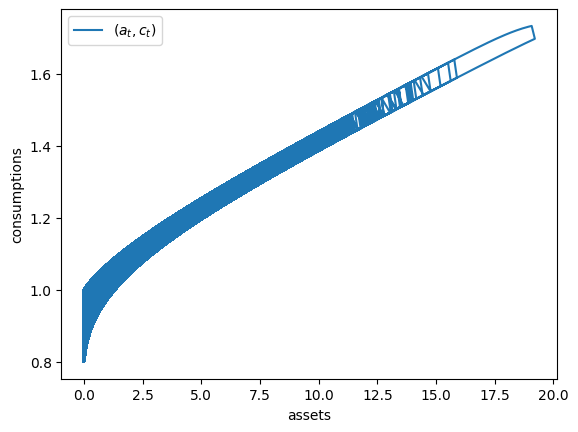

(array([0.        , 0.19861568, 0.38702952, ..., 2.86103647, 2.99662158,
        3.13092812]),
 array([1.00138432, 1.01853771, 1.03264488, ..., 1.16455116, 1.17057521,
        1.17647724]))

In [ ]:
# your code here

def Simulate_Time_Series(ifp, T=500_000, seed=1234, plot=True):

    r, w, P = ifp.r, ifp.w, ifp.P

    c_opt = solve_model_(ifp, σ_init, verbose=False)
    σ = lambda a, z: interp(ifp.asset_grid, c_opt[:, z], a)

    mc = MarkovChain(P)
    z_seq = mc.simulate(T, random_state=seed)

# a, c  numpy array 생성
    a = np.zeros(T+1)
    c = np.zeros(T)

# a, c numpy array 채우기
    for t in range(T):
        z = z_seq[t]
        c[t] = σ(a[t], z)
        a[t+1] = (1 + r[z]) * a[t] + w[z] - c[t]

# a[T+1]은 빼고 a를 다시 저장
    a = a[:T]

    if plot == 1:
        fig, ax = plt.subplots()
        ax.plot(a, c, label='$(a_t, c_t)$')
        ax.set(xlabel='assets', ylabel='consumptions')
        ax.legend()
        plt.show()

    return a, c

Simulate_Time_Series(ifp)

### Q.1-6: Plot the time-series of assets and consumption

- Generate time-series for asset and consumption.
- Plot histograms of assets and consumption assuming that the generated time-series represent the cross-sectional distributions of assets and consumption.
- Plot the Lorenz curve and compute the Gini coefficients for assets and consumption.


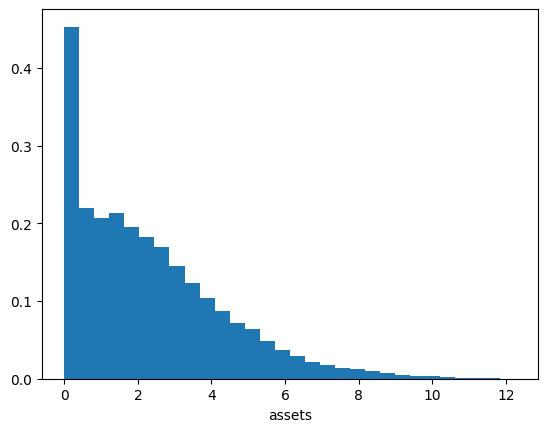

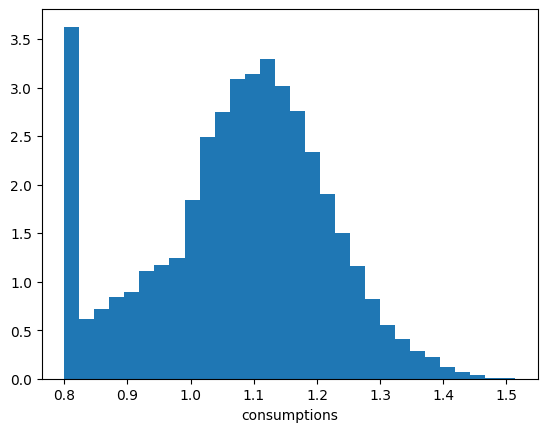

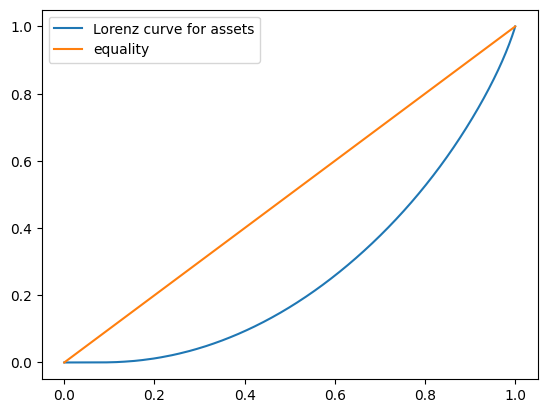

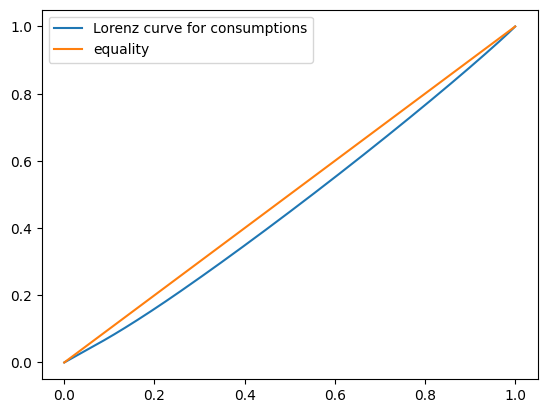

Gini coefficient of assets is 0.4685588514553937
Gini coefficient of consumptions is 0.07368317816273154


In [ ]:
# your code here

# T=500_000 일 때 run time이 오래 걸리므로 T=50_000으로 대체
a, c = Simulate_Time_Series(ifp, T=50_000, plot=False)

label = ['assets', 'consumptions']

# histogram
i = 0
for j in (a, c):
    fig, ax = plt.subplots()
    ax.hist(j, bins=30, density=True)
    ax.set(xlabel=label[i])
    plt.show()
    i += 1

# Lorenz curve
i = 0
for j in (a, c):
    fig, ax = plt.subplots()
    f_vals, l_vals = lorenz_curve(j)
    ax.plot(f_vals, l_vals, label=f'Lorenz curve for {label[i]}')
    ax.plot(f_vals, f_vals, label='equality')
    ax.legend()
    plt.show()
    i += 1

# Gini coefficient
i = 0
for j in (a, c):
    print('Gini coefficient of {} is {}'.format(label[i], gini_coefficient(j)))
    i += 1

## Question 2: Lake Model of Labor Markets

### The Model

The economy is inhabited by a very large number of ex-ante identical workers. Let's normalize the total number of workers (population) to unity. The workers live forever, spending their lives moving across three labor market states: employment ($E$), unemployment ($U$) and out of labor force ($O$). There are six possible transitions across three states over the course of two consecutive periods.

1. An employed worker in period $t$ becomes unemployed in the next period with probability $\alpha$.
1. An employed worker in period $t$ goes out of labor force in the next period with probability $\delta$.
1. An unemployed worker in period $t$ become employed in the next period with probability $\lambda$.
1. An unemployed worker in period $t$ goes out of labor firce in the next period with probability $\kappa$.
1. A worker out of labor force in period $t$ becomes employed in the next period with probability $\eta$.
1. A worker out of labor force in period $t$ becomes unemployed in the next period with probability $\chi$.


### Laws of Motion for Stock Variables

Labor market stock variables evolve over time according to the following laws of motion. 

1. Employment:
$$
E_{t+1} = (1-\alpha-\delta) E_t + \lambda U_t + \eta O_t
$$

1. Unemployment:
$$
U_{t+1} = \alpha E_t + (1-\lambda-\kappa) U_t + \chi O_t  
$$

1. Out of Labor Force:
$$
O_{t+1} = \delta E_t + \kappa U_t + (1-\eta-\chi) O_t
$$


Let $ X := \left(\begin{matrix} E & U & O \end{matrix}\right) $. Then the law of motion for $ X $ is $X_{t+1} = X_t P$, where 

$$
P = \left[\begin{matrix}
     1-\alpha-\delta & \alpha & \delta \\
     \lambda & 1-\lambda-\kappa & \kappa \\
     \eta & \chi & 1-\eta-\chi \\
    \end{matrix}\right]
$$


### Q.2-1: Define the class for the lake model of labor market

Write a class **Lake** that specifies the following. In the class definition, make the Markov matrix to immediately reflect changes in individual transition probabilities without re-creating the instance of the class. For this, Use descriptors and decorators such as `@property` as we did in the lecture.

- Transition probabilities
    - from E to U: $\alpha = 0.0147$
    - from E to O: $\delta = 0.0313$
    - from U to E: $\lambda = 0.2774$
    - from U to O: $\kappa = 0.2280$
    - from O to E: $\eta = 0.0466$
    - from O to U: $\chi = 0.0245$
- function `__init__`: sets default values for transition probabilities and generate a Markov matrix `P` by calling `construct_P`
- function `construct_P`: construct a Markov matrix `_P`
- function `construct_mc`: construct a Markov Chain object `_mc` with `P`
- using @property and @x.setter decorators, make inidividual transition probabilities and the Markov matrix to be changed.
- function `steady_state`: computes the steady state of the labor market
- function `simulate_stock_path`: simulate a time-series of labor market stock variables


In [ ]:
# your code here

class Lake:

    def __init__(self, alpha=0.0147, delta=0.0313, λ=0.2774, kappa=0.2280, eta=0.0466, chi=0.0245):
        self._alpha, self._delta, self._λ, self._kappa, self._eta, self._chi = alpha, delta, λ, kappa, eta, chi
        self.construct_P()
        self.construct_mc()

    def construct_P(self):
        alpha, delta, λ, kappa, eta, chi = self._alpha, self._delta, self._λ, self._kappa, self._eta, self._chi
        self._P = np.array([[1 - alpha - delta, alpha, delta],
                            [λ, 1 - λ - kappa, kappa],
                            [eta, chi, 1 - eta - chi]])
        
    def construct_mc(self):
        self._mc = MarkovChain(self._P)

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, new_value):
        self._alpha = new_value
        self.construct_P()
        self.construct_mc()

    @property
    def delta(self):
        return self._delta

    @delta.setter
    def delta(self, new_value):
        self._delta = new_value
        self.construct_P()
        self.construct_mc()

    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._λ = new_value
        self.construct_P()
        self.construct_mc()

    @property
    def kappa(self):
        return self._kappa

    @kappa.setter
    def kappa(self, new_value):
        self._kappa = new_value
        self.construct_P()
        self.construct_mc()

    @property
    def eta(self):
        return self._eta

    @eta.setter
    def eta(self, new_value):
        self._eta = new_value
        self.construct_P()
        self.construct_mc()

    @property
    def chi(self):
        return self._chi

    @chi.setter
    def chi(self, new_value):
        self._chi = new_value
        self.construct_P()
        self.construct_mc()

    @property
    def P(self):
        return self._P

    def steady_state(self, tol=1e-6):

        x = np.array([0.5, 0.3, 0.2])
        error = tol + 1
        while error > tol:
            new_x = x @ self.P
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):

        X = np.atleast_1d(X0)
        for t in range(T):
            yield X
            X = X @ self.P

### Q.2-2: Compute the stationary distribution

We have learned from the lecture 11 (Finite Markov Chain) that if the Markov matrix is both irreducible and aperiodic, then there exist a unique stationary distribution of states. 

- create an instance of the class, `LM`.

In [ ]:
# your code here

LM = Lake()

- check if the labor market is irreducible using a method in `quantecon.MarkovChain`

In [ ]:
# your code here

LM._mc.is_irreducible

True

- check if the labor market is aperiodic using a method in `quantecon.MarkovChain`

In [ ]:
# your code here

LM._mc.is_aperiodic

True

- compute the stationary distribution of labor market states using the function `stationary_distgribution` included in `quantecon.MarkovChain`.

In [ ]:
# your code here

LM._mc.stationary_distributions

array([[0.59122535, 0.03530098, 0.37347367]])

- compute the stationary distribution of labor market states using the function `steady_state` included in the class `Lake`.

In [ ]:
# your code here

LM.steady_state()

array([0.59123426, 0.03530078, 0.37346496])

### Q.2-3: Simulate Labor Market Stocks

Let's simulate labor market stock variables for 50 periods, `T=50`, according to the system that we constructed with the class `Lake`.

- set initial values for labor market stocks: `X_0`
- compute the steady state of the labor market: `xbar`
- simulate labor market stocks with the function `simulate_stock_path`.
- plot the simulated labor market stock variables with their steady states.


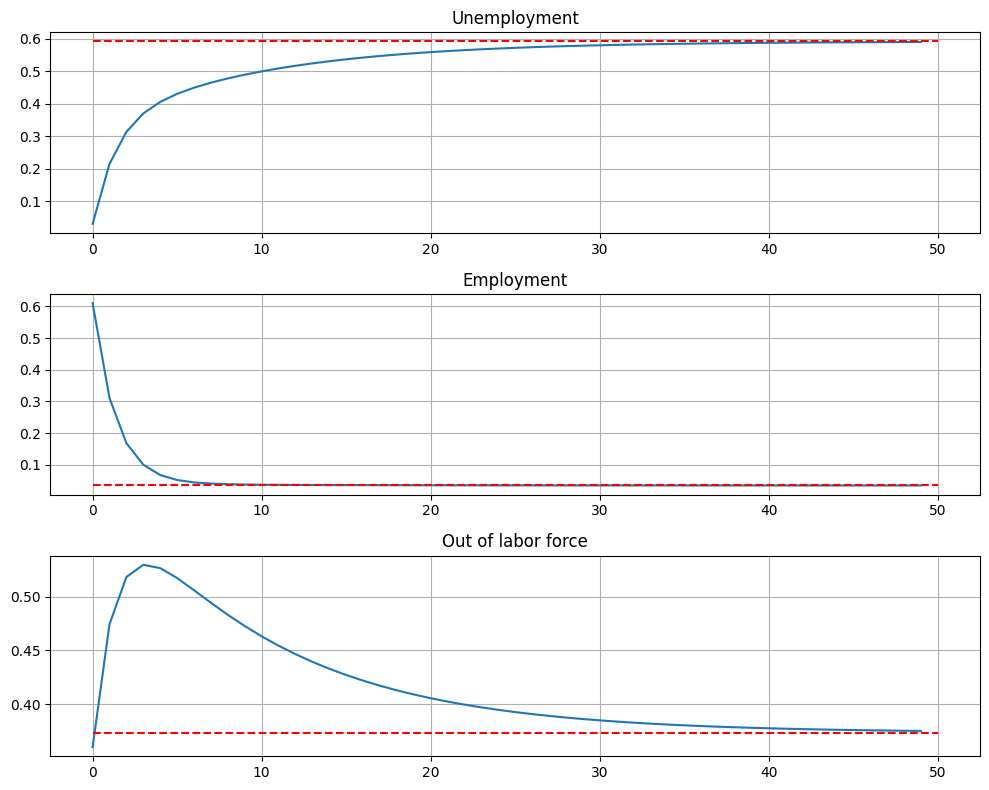

In [ ]:
# your code here

e_0 = 0.61
u_0 = 0.03
o_0 = 1 - e_0 - u_0

X_0 = (u_0, e_0, o_0)
T = 50
xbar = LM.steady_state()
x_path = np.vstack(tuple(LM.simulate_stock_path(X_0, T)))

label = ['Unemployment', 'Employment', 'Out of labor force']

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i in range(3):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(label[i])
    axes[i].grid()

plt.tight_layout()
plt.show()

### Q.2-4: An Invididual Worker's Turnover across Labor Market States

Let's simulate an individual worker's turnovers (transitions) across the labor market stock variables for $T=50,000$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time.

- simuate individual worker's state using Markov chain: `s_path`
- from `s_path`, construct a time series `e_path` that consists of 0 or 1 where 1 represents employment
- from `s_path`, construct a time series `u_path` that consists of 0 or 1 where 1 represents unemployment
- from `s_path`, construct a time series `o_path` that consists of 0 or 1 where 1 represents out of labor force
- using `e_path` generate a time series, `s_bar_e` of percentage of time employed until time $t$
- using `u_path` generate a time series, `s_bar_u` of percentage of time unemployed until time $t$
- using `o_path` generate a time series, `s_bar_o` of percentage of time out of labor force until time $t$
- plot `s_bar_e`, `s_bar_u`, `s_bar_o`

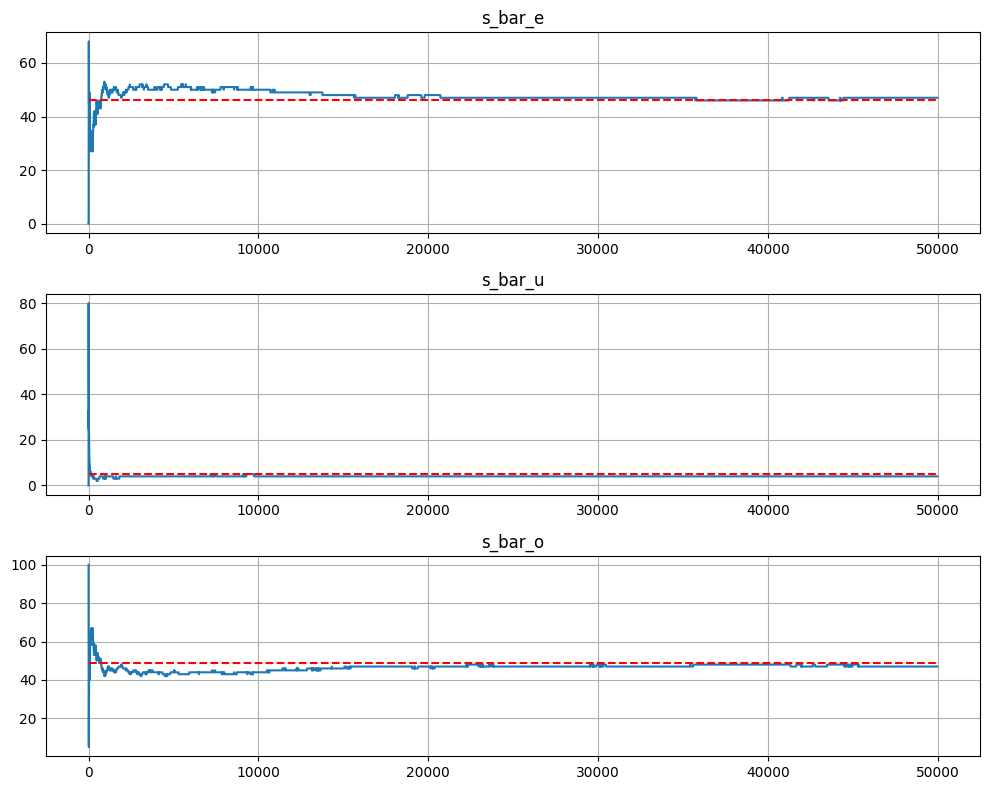

In [ ]:
# your code here

T = 50_000
s_path = LM._mc.simulate(ts_length=T)

# numpy where를 이용하여 numpy array 생성
e_path = np.where(s_path==0, 1, 0)
u_path = np.where(s_path==1, 1, 0)
o_path = np.where(s_path==2, 1, 0)

s_bar_e = np.empty_like(s_path)
s_bar_u = np.empty_like(s_path)
s_bar_o = np.empty_like(s_path)

# s_bar_*에 percentage 할당
for i in range(T):
    s_bar_e[i] = np.sum(e_path[0:i+1]) * 100 / (i+1)
    s_bar_u[i] = np.sum(u_path[0:i+1]) * 100 / (i+1)
    s_bar_o[i] = np.sum(o_path[0:i+1]) * 100 / (i+1)
    
xbar = LM.steady_state() * 100

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(s_bar_e)
axes[0].set_title('s_bar_e')
axes[1].plot(s_bar_u)
axes[1].set_title('s_bar_u')
axes[2].plot(s_bar_o)
axes[2].set_title('s_bar_o')
for i in range(3):
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].grid()

plt.tight_layout()
plt.show()

### Q.2-5: Effects of Changes in Transition Probabilities on Labor Market Stocks

Let's simulate the labor market stock variables for $T=50$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. In other words, exit probabilities from employment to either unemployment or out of labor force will increase. Write codes for simulating and plotting the labor market stocks as you did in Q.2-3.


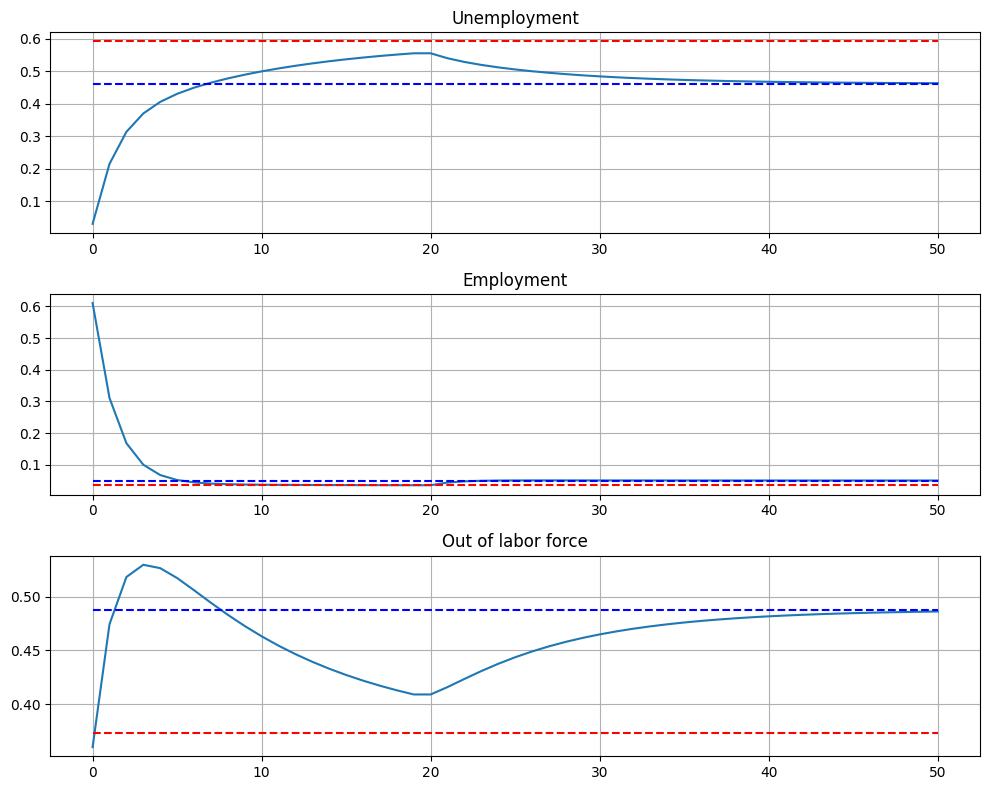

In [ ]:
# your code here

# alpha, delta 초기화
alpha, delta = 0.0147, 0.0313
LM.alpha = alpha
LM.delta = delta
T = 50
T_hat = 20
xbar1 = LM.steady_state()

e_0 = 0.61
u_0 = 0.03
o_0 = 1 - e_0 - u_0
X_0 = (u_0, e_0, o_0)

# T_hat기까지 simulate
X_path1 = np.vstack(tuple(LM.simulate_stock_path(X_0, T_hat)))

# alpha, delta 할당
alpha_hat, delta_hat = 0.03, 0.05
LM.alpha = alpha_hat
LM.delta = delta_hat

# T_hat기 후로 X_path1 마지막 값을 초기값으로 주고 simulate
X_path2 = np.vstack(tuple(LM.simulate_stock_path(X_path1[-1, :], T - T_hat + 1)))

xbar2 = LM.steady_state()
X_path = np.vstack([X_path1, X_path2])

label = ['Unemployment', 'Employment', 'Out of labor force']

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# red line은 'steady state when $\alpha = 0.0147, \delta = 0.0313$'
# blue line은 'steady state when $\alpha = 0.03, \delta = 0.05$'
for i in range(3):
    axes[i].plot(X_path[:, i])
    axes[i].hlines(xbar1[i], 0, T, 'r', '--', label='steady state when $\alpha = 0.0147, \delta = 0.0313$')
    axes[i].hlines(xbar2[i], 0, T, 'b', '--', label='steady state when $\alpha = 0.03, \delta = 0.05$')
    axes[i].set_title(label[i])
    axes[i].grid()

plt.tight_layout()
plt.show()

### Q.2-6: Effects of Changes in Transition Probabilities on Individual Worker's Turnovers in the Labor Market

Let's simulate an individual worker's turnovers in the labor market stock variables for $T=50,000$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20,000$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time as you did in Q.2-4.


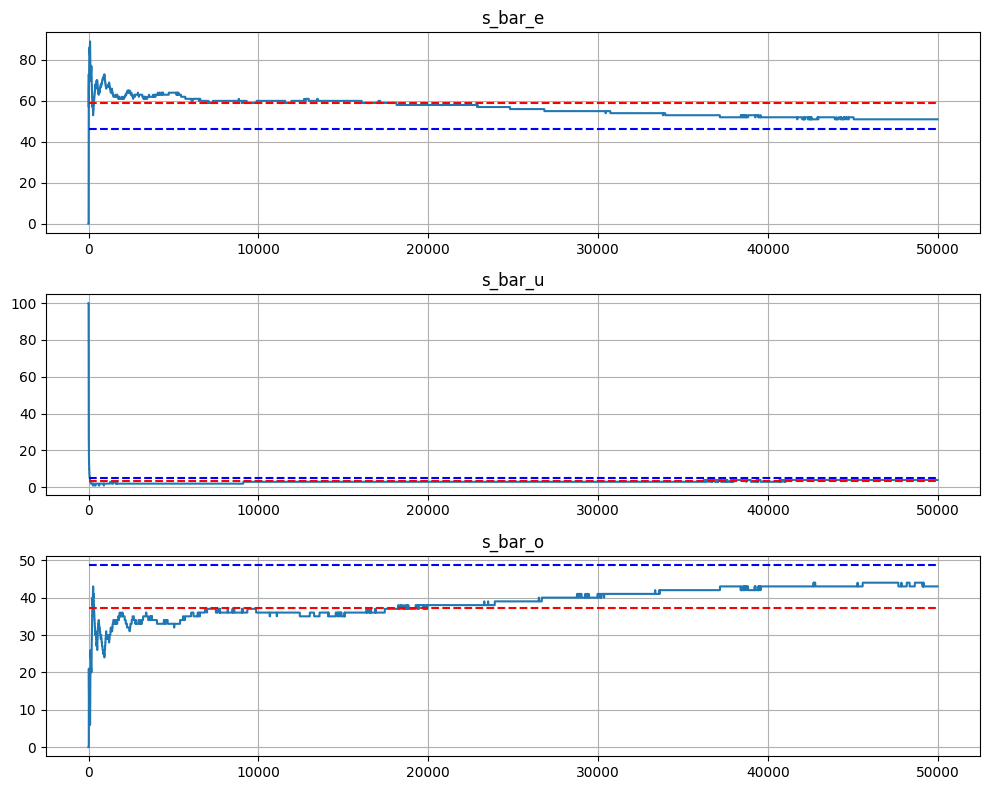

In [ ]:
# your code here

# your code here

# alpha, delta 초기화
alpha, delta = 0.0147, 0.0313
LM.alpha = alpha
LM.delta = delta

T = 50_000
T_hat = 20_000

# T_hat기까지 simulate
s_path1 = LM._mc.simulate(ts_length=T_hat)
# numpy where를 이용하여 numpy array 생성
e_path1 = np.where(s_path1==0, 1, 0)
u_path1 = np.where(s_path1==1, 1, 0)
o_path1 = np.where(s_path1==2, 1, 0)

xbar1 = LM.steady_state() * 100

alpha_hat, delta_hat = 0.03, 0.05
LM.alpha = alpha_hat
LM.delta = delta_hat

# T_hat기 후로 s_path1 마지막 값을 초기값으로 주고 simulate
s_path2 = LM._mc.simulate(ts_length=(T-T_hat), init=s_path1[-1])
# numpy where를 이용하여 numpy array 생성
e_path2 = np.where(s_path2==0, 1, 0)
u_path2 = np.where(s_path2==1, 1, 0)
o_path2 = np.where(s_path2==2, 1, 0)

xbar2 = LM.steady_state() * 100

e_path = np.concatenate((e_path1, e_path2))
u_path = np.concatenate((u_path1, u_path2))
o_path = np.concatenate((o_path1, o_path2))

s_bar_e = np.empty_like(s_path)
s_bar_u = np.empty_like(s_path)
s_bar_o = np.empty_like(s_path)

# s_bar_*에 percentage 할당
for i in range(T):
    s_bar_e[i] = np.sum(e_path[0:i+1]) * 100 / (i+1)
    s_bar_u[i] = np.sum(u_path[0:i+1]) * 100 / (i+1)
    s_bar_o[i] = np.sum(o_path[0:i+1]) * 100 / (i+1)
    
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# red line은 'steady state when $\alpha = 0.0147, \delta = 0.0313$'
# blue line은 'steady state when $\alpha = 0.03, \delta = 0.05$'
axes[0].plot(s_bar_e)
axes[0].set_title('s_bar_e')
axes[1].plot(s_bar_u)
axes[1].set_title('s_bar_u')
axes[2].plot(s_bar_o)
axes[2].set_title('s_bar_o')
for i in range(3):
    axes[i].hlines(xbar1[i], 0, T, 'r', '--', label='steady state when $\alpha = 0.0147, \delta = 0.0313$')
    axes[i].hlines(xbar2[i], 0, T, 'b', '--', label='steady state when $\alpha = 0.03, \delta = 0.05$')
    axes[i].grid()

plt.tight_layout()
plt.show()